In [24]:
import pandas as pd
import numpy as np
import os
import sys
from trimesh import load_mesh
sys.path.append('/root/capsule/code/beh_ephys_analysis')
from utils.ccf_utils import ccf_pts_convert_to_mm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

In [25]:
data_dir = '~/capsule/scratch/combined/merfish/spatial_with_pseudocluster.csv'
merfish_ccf = pd.read_csv(data_dir)

In [26]:
ccf_merfish = merfish_ccf[['AP', 'DV', 'ML']].values
ccf_merfish = ccf_merfish/25
ccf_merfish_mm = ccf_pts_convert_to_mm(ccf_merfish)
# ccf_merfish_mm = ccf_merfish/1000
bregma = np.array([216, 18, 228])

In [27]:
ml, ap, dv = 0, 2, 1
ml_mesh, ap_mesh, dv_mesh = 2, 0, 1
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}
planes_mesh = {'sag': [ap_mesh, dv_mesh], 'hor': [ml_mesh, ap_mesh], 'cor': [ml_mesh, dv_mesh]}

In [28]:
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices_mm = ccf_pts_convert_to_mm(mesh_vertices)
ccf_center = np.mean(mesh_vertices_mm, axis=0)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import statsmodels.api as sm

# linear regression using ccf as predictor and psuedocluster as response
filter_LC = ccf_merfish_mm[:, dv_mesh] < 10 # 4.7
X = sm.add_constant(ccf_merfish_mm[filter_LC])
model = sm.OLS(merfish_ccf[filter_LC]['pseudocluster'], X)
result = model.fit()

primary_axis_vector_LR = result.params[1:] * np.sign(result.params[2])  # First linear discriminant

# Display the primary axis of variation
primary_axis_vector_LR = primary_axis_vector_LR / np.linalg.norm(primary_axis_vector_LR)
print("Primary axis of variation (in MLR space):", primary_axis_vector_LR)
result.summary()

Primary axis of variation (in MLR space): x1    0.774943
x2    0.497537
x3   -0.389769
dtype: float64


/tmp/ipykernel_9777/3502586499.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  primary_axis_vector_LR = result.params[1:] * np.sign(result.params[2])  # First linear discriminant


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pseudocluster   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     349.2
Date:                Sun, 17 Aug 2025   Prob (F-statistic):          5.02e-191
Time:                        18:22:04   Log-Likelihood:                 2092.3
No. Observations:                2651   AIC:                            -4177.
Df Residuals:                    2647   BIC:                            -4153.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2986      0.070      4.236      0.000       0.160       0.437
x1            -0.1009      0.012     -8.120      0.000      -0.125      -0.077
x2            -0.0648      0.005    -12.646      0.000      -0.075      -0.055
x3             0.0507      0.013      3.808      0.000       0.025       0.077
==============================================================================
Omnibus:                       35.283   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.743
Skew:                           0.268   Prob(JB):                     1.05e-08
Kurtosis:                       3.212   Cond. No.                         225.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

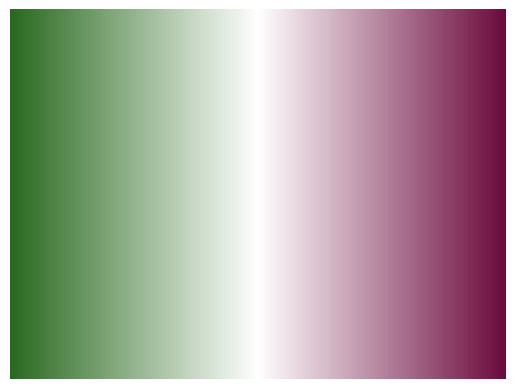

In [30]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# RGB values normalized to 0–1
dark_green = (42/255, 106/255, 32/255)
white = (1, 1, 1)
dark_magenta = (108/255, 11/255, 61/255)

# Create diverging colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "green_white_magenta",
    [dark_green, white, dark_magenta]
)

# Show gradient
plt.imshow([range(256)], aspect="auto", cmap=cmap)
plt.axis("off")
plt.show()


In [33]:
merfish_ccf['pseudocluster']

0       0.402062
1       0.304457
2       0.403029
3       0.302312
4       0.433363
          ...   
2646    0.662052
2647    0.657780
2648    0.522499
2649    0.422672
2650    0.531128
Name: pseudocluster, Length: 2651, dtype: float64

Cluster: 0.4020622177426708 Color: [0.90111496 0.54702038 0.75140331 1.        ]


/tmp/ipykernel_9777/1750896655.py:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_9777/1750896655.py:62: UserWarning: Adding colorbar to a different Figure <Figure size 1800x600 with 4 Axes> than <Figure size 3000x1000 with 4 Axes> which fig.colorbar is called on.
  plt.colorbar(sc, ax=ax, label="pseudocluster", fraction=0.046, pad=0.04)


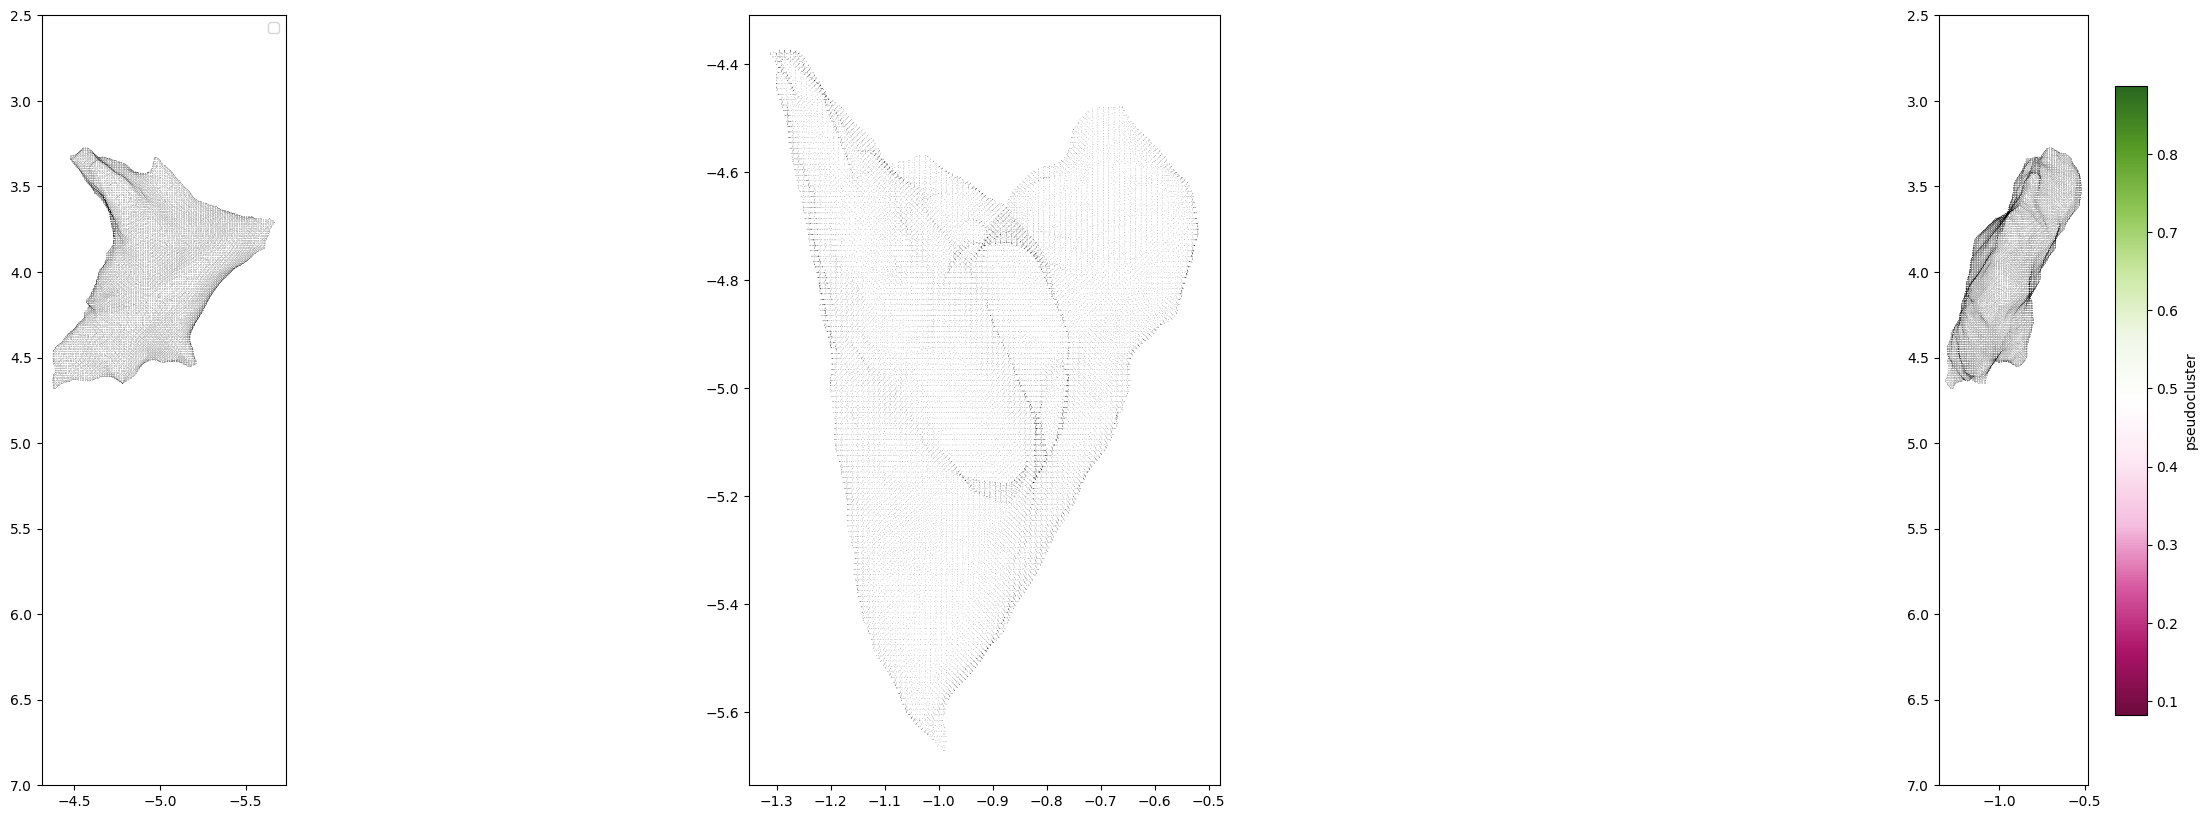

In [52]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Define custom colormap
dark_green = (42/255, 106/255, 32/255)
white = (1, 1, 1)
dark_magenta = (108/255, 11/255, 61/255)

green_white_magenta = mpl.colors.LinearSegmentedColormap.from_list(
    "green_white_magenta",
    ['#6c0b3d', '#ac1468','#d758a0', '#f4bdde', '#fde7f2', '#FFFFFF','#f0f7e7', '#cce9a4', '#91c757', '#589c26', '#29671f']
)
# get the colar for each pseudocluster number
# Number of unique pseudoclusters
n_clusters = merfish_ccf['pseudocluster'].nunique()

# Get evenly spaced colors from the colormap
pseudocluster_colors = green_white_magenta(np.linspace(0, 1, n_clusters))

# Map each unique cluster number to a color
pseudocluster_to_color = {
    cluster: pseudocluster_colors[i]
    for i, cluster in enumerate(sorted(merfish_ccf['pseudocluster'].unique()))
}

# Example usage:
example_cluster = merfish_ccf['pseudocluster'].iloc[0]
print("Cluster:", example_cluster, "Color:", pseudocluster_to_color[example_cluster])


fig = plt.figure(figsize=(30, 10))
gs = fig.add_gridspec(1, 3)

for plane, ax_ind in zip(planes.keys(), range(3)):
    ax = fig.add_subplot(gs[ax_ind])

    # Plot the mesh
    ax.scatter(
        mesh_vertices_mm[:, planes_mesh[plane][0]],
        mesh_vertices_mm[:, planes_mesh[plane][1]],
        color="k", alpha=0.8, s=0.1, edgecolors="none"
    )

    # Use custom colormap for pseudocluster values
    # sc = ax.scatter(
    #     ccf_merfish_mm[filter_LC, planes_mesh[plane][0]],
    #     ccf_merfish_mm[filter_LC, planes_mesh[plane][1]],
    #     c=merfish_ccf[filter_LC]['pseudocluster'],
    #     cmap=green_white_magenta,
    #     alpha=1, s=10
    # )
    # for unit_ind in range(len(merfish_ccf['pseudocluster'])):
    #     ax.scatter(ccf_merfish_mm[unit_ind, planes_mesh[plane][0]],
    #                 ccf_merfish_mm[unit_ind, planes_mesh[plane][1]],
    #                 color="none",
    #                 alpha=1, s=25, edgecolors=pseudocluster_to_color[merfish_ccf['pseudocluster'][unit_ind]],
    #                 linewidths=1
    #     )

    # Optional: add colorbar
    if ax_ind == 2:  
        plt.colorbar(sc, ax=ax, label="pseudocluster", fraction=0.046, pad=0.04)

    if plane == "sag":
        ax.legend()
    if planes[plane][1] == dv:
        ax.set_ylim(2.5, 7)
        ax.invert_yaxis()
    
    if planes[plane][0] == ap:
        ax.invert_xaxis()
    ax.set_aspect(aspect="equal")

fig.savefig('/root/capsule/scratch/combined/merfish/merfish_ccf_pseudocluster.pdf', dpi=300, bbox_inches='tight')


In [41]:
pseudocluster_to_color[merfish_ccf['pseudocluster'][unit_ind]]

array([0.90111496, 0.54702038, 0.75140331, 1.        ])

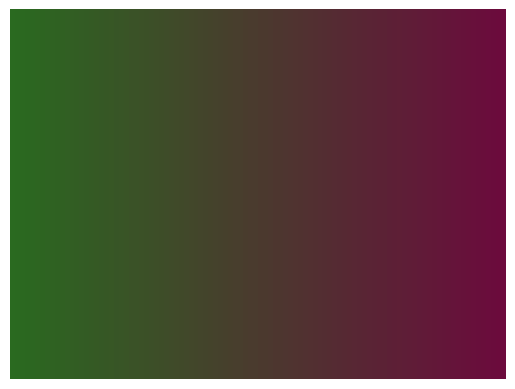

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Convert RGB from 0–255 to 0–1
start = (42/255, 106/255, 32/255)
end   = (108/255, 11/255, 61/255)

# Create a colormap blending those two colors
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "green_to_magenta",
    [start, end]
)

# Visualize the gradient
plt.imshow([range(100)], aspect="auto", cmap=cmap)
plt.axis('off')
plt.show()
